## COMP 341: Practical Machine Learning
## Homework Assignment 3: Cerebrovascular Accident Prediction
### Due: Tuesday, October 4 at 11:59pm on Gradescope

Cerebrovascular accidents (CVAs), also known as strokes, occur when blood flow to the brain is interrupted by a blockage or a rupture of a blood vessel. Understanding them is important since they are one of the leading causes of death not only in the United States but globally. Currently, we know that there are certain lifestyle factors (exercise, smoking, weight, etc) and pre-existing health conditions (high blood pressure, diabetes, etc) associated with the likelihood of developing a stroke, but the exact contribution of these factors or the ranges which trigger a stroke remains unknown.

In this assignment we will attempt to predict whether or not someone has had a CVA given a snapshot of their health and demographic information. Helpful predictive models as well as the feature importances we can extract can have downstream positive effects for public health, allowing doctors to work together with patients to suggest early actions reduce stroke risk in individuals with high risk features.

As always, fill in missing code following `# TODO:` comments or `####### YOUR CODE HERE ########` blocks and be sure to answer the short answer questions marked with `[WRITE YOUR ANSWER HERE]` in the text.

All code in this notebook will be run sequentially so make sure things work in order! Be sure to also use good coding practices (e.g., logical variable names, comments as needed, etc), and make plots that are clear and legible.

For this assignment, there will be **15 points** allocated for general coding points:
* **10 points** for coding style
* **5 points** for code flow (accurate results when everything is run sequentially)

### Setup
First, we need to import some libraries that are necessary to complete the assignment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

Add additional modules/libraries to import here (rather than wherever you first use them below):

In [ ]:
# additional modules/libraries to import
from plotnine import *
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import graphviz

We provide some code to get the data file for this assignment into your workspace below. You only need to do the following 4 steps once:
1. Go to 'My Drive' in your own Google Drive
2. Make a new folder named `comp341`
3. From the [Google Drive link](https://drive.google.com/file/d/1IeVuSD3tjZpthDmGLUIUXVkIODIFWzq8/view?usp=sharing), click Download. You should now have a single file entitled `CVA.csv` on your computer.
4. In the `comp341` folder you created in step 2, click `New -> File Upload` and select the `CVA.csv` folder from your computer.

Now, we will mount your local Google Drive in colab so that you can read the file in (you will need to do this each time your runtime restarts).

In [ ]:
# note that this command will trigger a request from google to allow colab
# to access your files: you will need to accept the terms in order to access
# the files this way
from google.colab import drive
drive.mount('/content/drive')

# if you followed the instructions above exactly, CVA.csv should be
# in comp341/; if your files are in a different directory
# on your Google Drive, you will need to change the path below accordingly
DATADIR = '/content/drive/My Drive/comp341/'

Mounted at /content/drive


Now that your Google Drive is mounted, you can read in the data in `CVA.csv` into a pandas DataFrame:

In [ ]:
df = pd.read_csv(DATADIR + "CVA.csv")

### Part 0: Getting Familiar with the Data [13 points]
This time we are starting with tidy data (yay!), but we still need to get a feel for what is going on. One quick way is to check some basic dataset attributes such as identifying the number of individuals measured, the types of features, the number of missing values and where they occur, and distribution of the labels (CVA vs no CVA).

Use the code area below to explore the data, and answer the two short answer questions that follow. (Note: You are free to take whichever approach to find the answers to the questions, i.e., the code itself will not be graded, but your answers to the short answer questions will be.)

In [ ]:
# explore the data to answer the two short answer questions below
####### YOUR CODE HERE #########

df.shape
df.head()

,id,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,CVA
0,1,Female,17.0,0,0,No,Private,Urban,92.97,NaN,formerly smoked,0
1,2,Female,13.0,0,0,No,children,Rural,85.81,18.6,Unknown,0
2,3,Male,55.0,0,0,Yes,Private,Urban,89.17,31.5,never smoked,0
3,4,Female,42.0,0,0,No,Private,Urban,98.53,18.5,never smoked,0
4,5,Female,31.0,0,0,No,Private,Urban,108.89,52.3,Unknown,0


**Short Answer Question:** How many individuals in this dataset?

`[WRITE YOUR ANSWER HERE]`

5109 individuals

**Short Answer Question:** List the nominal features, ordinal features, and numeric features in this data.



`[WRITE YOUR ANSWER HERE]`

Nominal:

1. sex
2. hypertension
3. heart_disease
4. ever_married
5. work_type
6. residence_type
7. CVA

Ordinal:

1. id
2. smoking status

Numeric:

1. age
2. avg_glucose_level
3. bmi



In [ ]:
df["sex"].value_counts()

Female    2994
Male      2115
Name: sex, dtype: int64

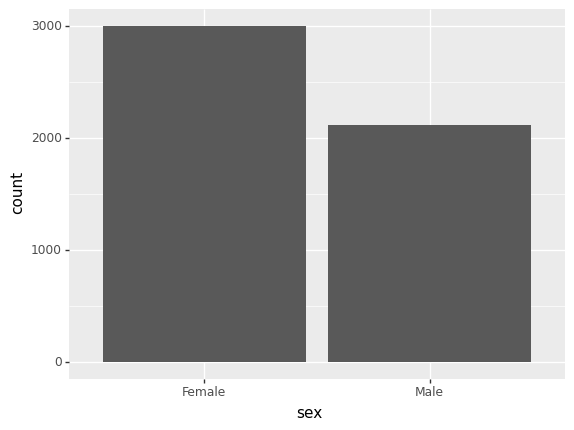

<ggplot: (8754829568585)>

In [ ]:
sex = df['sex'].value_counts().reset_index().rename(columns={"index":"sex", "sex":"count"})
(ggplot(sex, aes(x="sex", weight="count"))
+ geom_bar())

In [ ]:
df["age"].min()

0.08

In [ ]:
df["age"].max()

82.0

In [ ]:
df.loc[df.age < 25].shape

(1235, 12)

In [ ]:
df.loc[(df.age >= 25) & (df.age < 50)].shape

(1656, 12)

In [ ]:
df.loc[(df.age >= 50) & (df.age < 75)].shape

(1690, 12)

In [ ]:
df.loc[df.age >= 75].shape

(514, 12)

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 14 rows containing non-finite values.


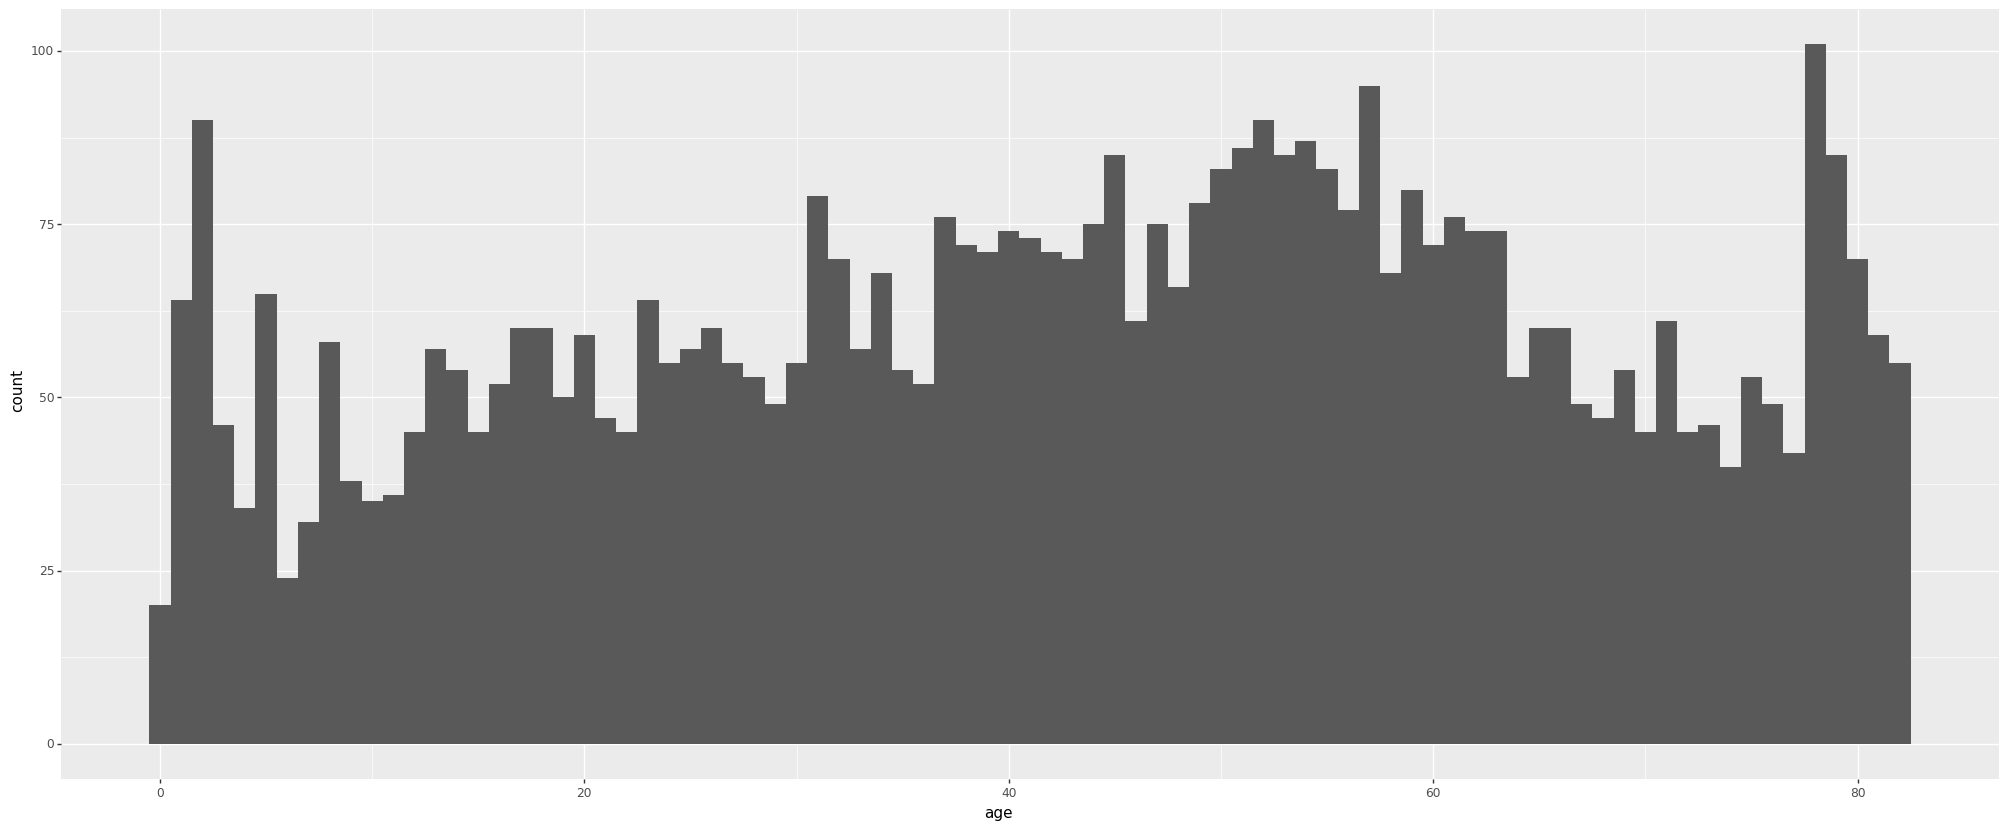

<ggplot: (8754826867773)>

In [ ]:
age = df["age"].reset_index()
(ggplot(age, aes(x="age"))
+ geom_histogram(binwidth=1)
 + theme(figure_size=(25, 10)))

In [ ]:
df["hypertension"].value_counts()

0    4611
1     498
Name: hypertension, dtype: int64

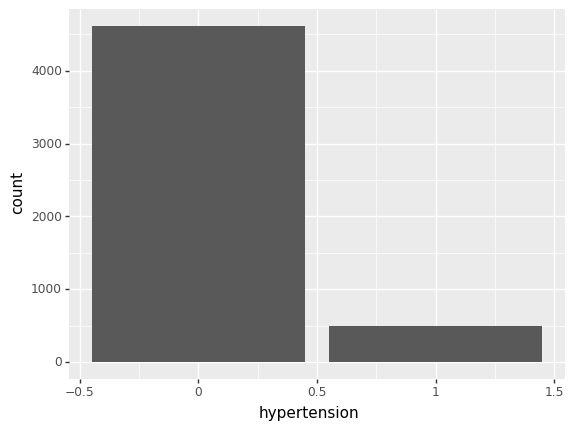

<ggplot: (8754826838457)>

In [ ]:
hypertension = df["hypertension"].value_counts().reset_index().rename(columns={"hypertension":"count","index":"hypertension"})
(ggplot(hypertension, aes(x="hypertension", weight="count"))
+ geom_bar())

In [ ]:
df["heart_disease"].value_counts()

0    4833
1     276
Name: heart_disease, dtype: int64

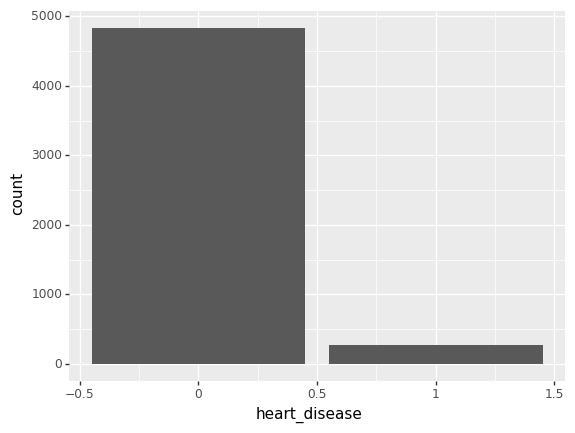

<ggplot: (8754826790297)>

In [ ]:
heart_disease = df["heart_disease"].value_counts().reset_index().rename(columns={"heart_disease":"count","index":"heart_disease"})
(ggplot(heart_disease, aes(x="heart_disease", weight="count"))
+ geom_bar())

In [ ]:
df["ever_married"].value_counts()

Yes    3353
No     1756
Name: ever_married, dtype: int64

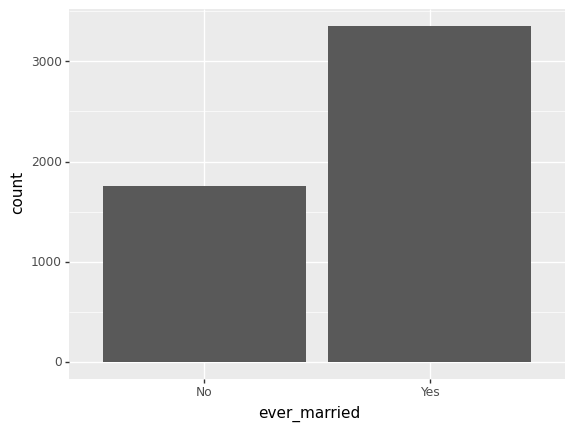

<ggplot: (8754826762605)>

In [ ]:
ever_married = df["ever_married"].value_counts().reset_index().rename(columns={"ever_married":"count","index":"ever_married"})
(ggplot(ever_married, aes(x="ever_married", weight="count"))
+ geom_bar())

In [ ]:
df["work_type"].value_counts()

Private          2924
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

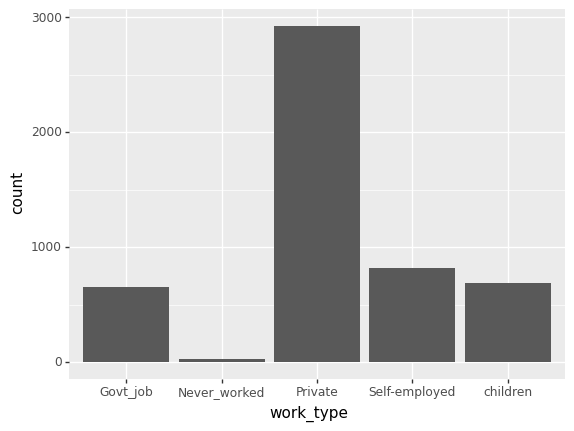

<ggplot: (8754826704233)>

In [ ]:
work_type = df["work_type"].value_counts().reset_index().rename(columns={"index":"work_type", "work_type": "count"})
(ggplot(work_type, aes(x="work_type", weight="count"))
+ geom_bar())

In [ ]:
df["residence_type"].value_counts()

Urban    2596
Rural    2513
Name: residence_type, dtype: int64

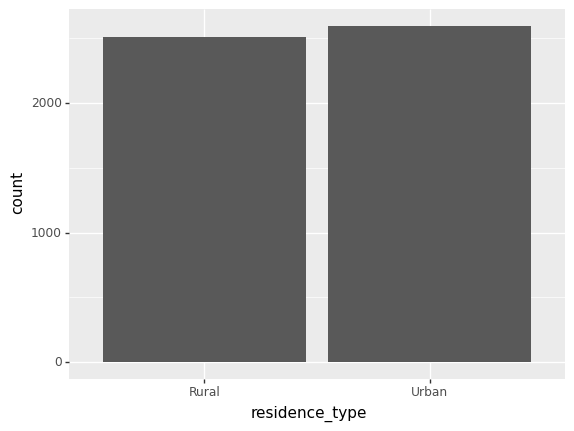

<ggplot: (8754826673925)>

In [ ]:
residence_type = df["residence_type"].value_counts().reset_index().rename(columns={"index":"residence_type", "residence_type": "count"})
(ggplot(residence_type, aes(x="residence_type", weight="count"))
+ geom_bar())

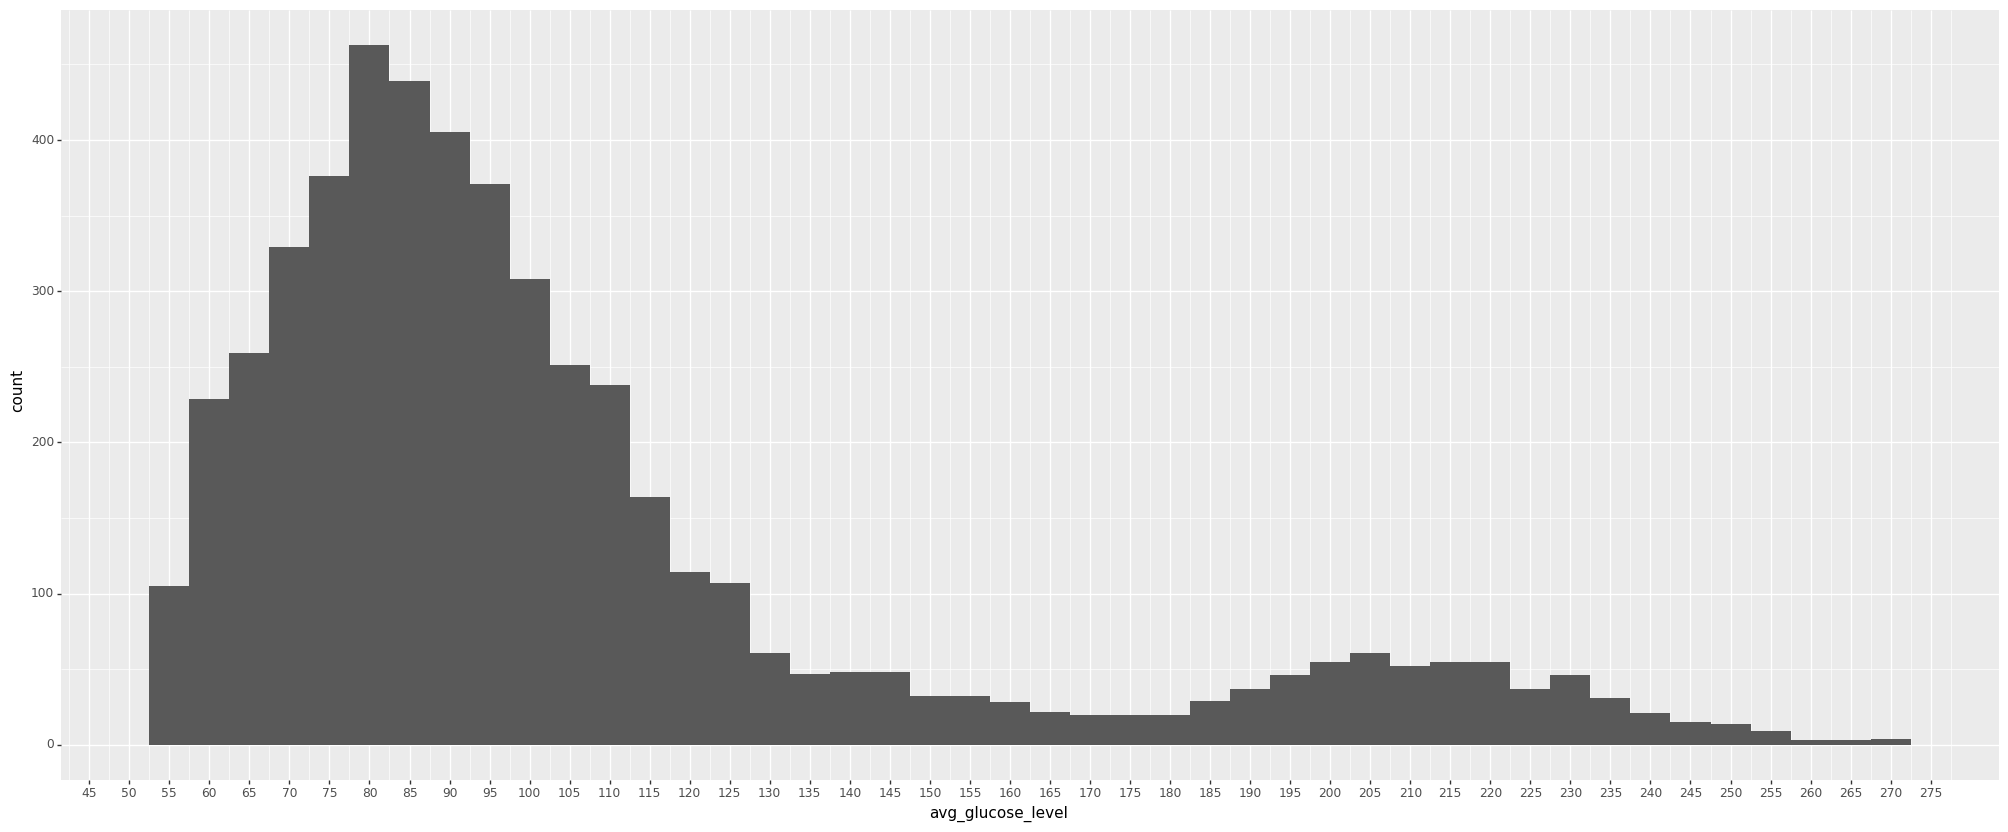

<ggplot: (8754826638825)>

In [ ]:
avg_glucose_level = df["avg_glucose_level"].reset_index()
(ggplot(avg_glucose_level, aes(x="avg_glucose_level"))
+ geom_histogram(binwidth=5)
 + scale_x_continuous(breaks = list(range(0, 280, 5)))
 + theme(figure_size=(25, 10)))

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:324: PlotnineWarning: stat_bin : Removed 201 rows containing non-finite values.


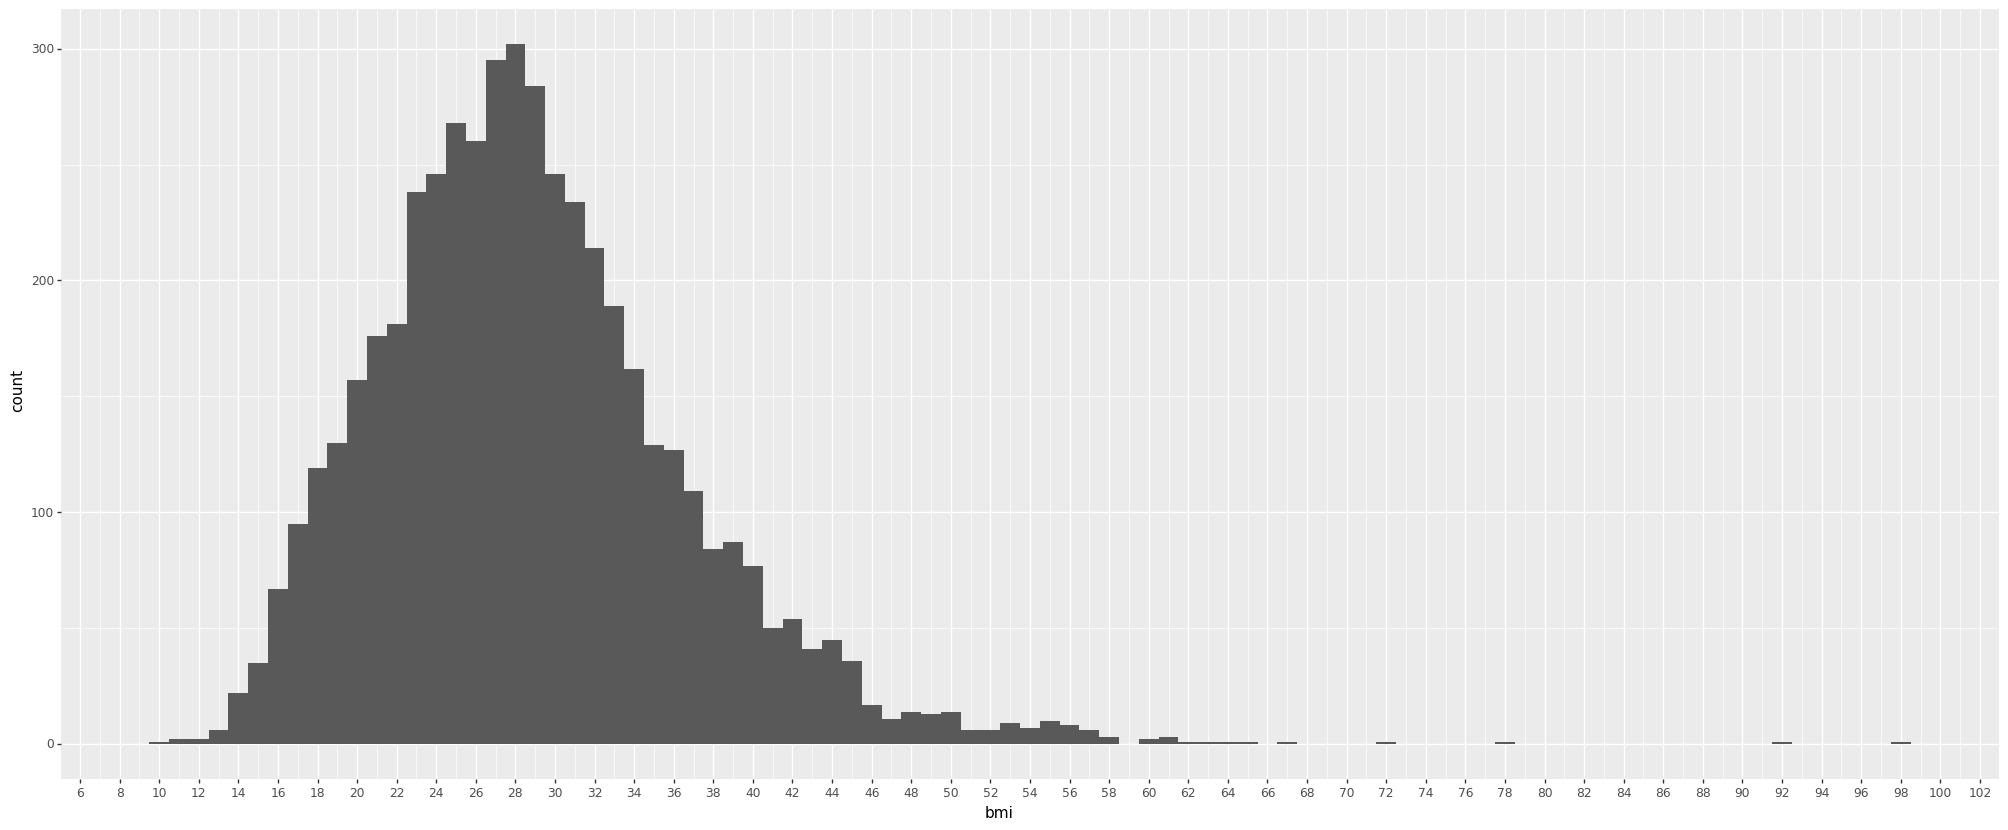

<ggplot: (8754826561049)>

In [ ]:
bmi = df["bmi"].reset_index()
(ggplot(bmi, aes(x="bmi"))
+ geom_histogram(binwidth=1)
 + scale_x_continuous(breaks = list(range(0, 120, 2)))
 + theme(figure_size=(25, 10)))

In [ ]:
df["smoking_status"].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

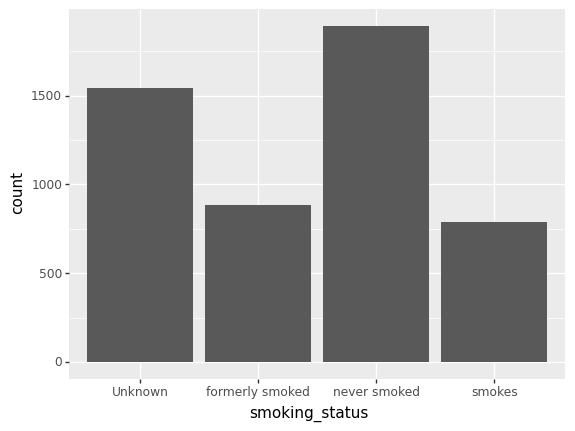

<ggplot: (8754826425269)>

In [ ]:
smoking_status = df["smoking_status"].value_counts().reset_index().rename(columns={"index":"smoking_status", "smoking_status": "count"})
(ggplot(smoking_status, aes(x="smoking_status", weight="count"))
+ geom_bar())

**Short Answer Question:** What's the breakdown for all features in the dataset (excluding CVA and non-predictive ones)? Make use of descriptive/informative plots that make sense for the corresponding data type.

sex:


*   There are 2994 females and 2115 males.
*   There are more females than males in the data set

age:

*   The youngest person is 0.08 years old and the oldest is 82 years old.
*   There are 1235 people below the age of 25
*   There are 1656 people with age >= 25 and < 50
*   There are 1690 people with age >= 50 and < 75
*   There are 514 people with age >= 75
*   Most people in the data set are between 50 and 75 years old

hypertension

* There are 4611 people without hypertension and 498 people with hypertension

heart disease

* There are 4833 people without heart disease and 276 people with heart disease

ever_marriage

* There 3353 people who has been married and 1756 people who has never
* Nearly twice as many people has been married

work type

* Most people work in private sector (2924)
* The amount of people worked in government jobs (657), self-employed (819), and children (687) are relatively about the same
* Almost no one has never worked (22)

residence type

* The amount of people living in urban areas (2596) and rural areas (2513) are about the same

average glucose level

* Most people have average glucose level between 55 and 135
* A noticeable amount of people have average glucose level between 185 and 250
* The largest group (around 450 people) have average glucose level between 80 and 85

bmi

* Most people have bmi between 15 and 45
* The largest group of people have bmi around 28

smoking status

* 1892 people has never smoked, 1544 people is unknown, 884 formerly smoked, and 789 smokes
* Most people has never smoked
* The amount of people who has formerly smoked and smokes are about the same

In [ ]:
# TODO: how many individuals in this dataset have had a CVA?
df["CVA"].value_counts() # 254 people

0    4855
1     254
Name: CVA, dtype: int64

In [ ]:
# TODO: data completeness: how many rows are affected by missing values? how many columns?

df.isna().any(axis=1).sum() # 241 rows
df.isna().any(axis=0).sum() # 2 columns
df.shape

(5109, 12)

**Short Answer Question:** Without any additional coding - do you think the missing values determined above will be problematic during our classification task? Why or why not?

`[WRITE YOUR ANSWER HERE]`

No because relatively small amount of rows are missing values compared to the entire dataset, and they are all within just two columns. We can impute the values later on if needed.

**Short Answer Question:** Again without additional coding - which features do you think will be the most informative? Explain. (Don't panic-- there are no wrong answers here as long as you've explain some rationale.)

`[WRITE YOUR ANSWER HERE]`

I think that hypertension and heart disease will be the most informative features because they are a health condition which is directly linked to stroke. They are also informative features in that they are a reflection of other features; certain life style and conditions leads to having hypertension and heart disease, e.g. smoking, working stressful jobs, marriage, age may causes hypertension and heart disease.

Before we begin running any methods we need to set aside some samples so that we can evaluate how well our trained models are doing in the later sections. This is referred to as splitting our data into a training and a test set. We give some code that does the splitting portion so everyone will have consistent splits, but we need to first transform our data into a set of features and a set of labels (the column that holds predictions). Recall that by convention in ML the features are referred to a matrix or dataframe called X and the prediction labels in a vector called y.

In [ ]:
# TODO: separate the features from the prediction labels (CVA) into
# two data frames, X and y, respectively
# for X, think about what features would be useful for downstream prediction

X = df.drop(['CVA', 'id'], axis=1)
y = df["CVA"]

In [ ]:
# this next snippet of code is provided so that everyone will have the same test and training split
# the percentage of data to take for test is specified by test_size, and since rows are chosen at random
# the random_state parameter sets the seed that keeps the test reproducible
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40, random_state=6)

In [ ]:
# TODO: fill in missing values by mean imputation for each of the feature(s) that have missing values
# we want to do this after the test/train split so that the train and test datasets
# do not use the other set of data to impute its values

X_train_age_mean = X_train.age.mean()
X_train_bmi_mean = X_train.bmi.mean()
X_train = X_train.fillna(value={"age": X_train_age_mean, "bmi":X_train_bmi_mean})

X_test_age_mean = X_test.age.mean()
X_test_bmi_mean = X_test.bmi.mean()
X_test = X_test.fillna(value={"age": X_test_age_mean, "bmi":X_test_bmi_mean})

### Part 1: Decision Trees [30 points]
In this first part we will run decision trees carving up the underlying data in different ways and observing changes in classification performance. Unless specified, for the remainder of the homework we will be evaluating classification performance using the accuracy of predictions made on the test set.

In [ ]:
# TODO: run decision trees (using default parameters) to predict CVAs on numeric (continous valued features) only
# evaluating accuracy on the test dataset

continuous_train = X_train[["age", "avg_glucose_level", "bmi"]].copy()
continuous_test = X_test[["age", "avg_glucose_level", "bmi"]].copy()

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(continuous_train, y_train)
pred = dt_clf.predict(continuous_test)
accuracy_score(y_test, pred)

0.912426614481409

In [ ]:
# TODO: convert any categorical features that need to be one-hot encoded

ct = make_column_transformer(
    (OneHotEncoder(), ["sex", "hypertension", "heart_disease", "ever_married", "work_type", "residence_type", "smoking_status"]),
    remainder="passthrough",
    verbose_feature_names_out=False
)

encoded_train = ct.fit_transform(X_train)
encoded_train = pd.DataFrame(data=encoded_train, columns=ct.get_feature_names_out())

encoded_test = ct.fit_transform(X_test)
encoded_test = pd.DataFrame(data=encoded_test, columns=ct.get_feature_names_out())
encoded_train

,sex_Female,sex_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Never_worked,...,work_type_children,residence_type_Rural,residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,age,avg_glucose_level,bmi
0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,40.0,88.81,32.7
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,36.0,114.16,21.3
2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,35.0,87.72,21.3
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,37.0,77.37,21.4
4,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,45.0,110.47,24.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3060,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,78.0,85.03,26.1
3061,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,64.0,78.85,33.9
3062,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,11.0,90.69,18.6
3063,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,25.0,68.78,55.1


In [ ]:
# TODO: train a decision tree model (again default) with all categorical and numeric features
# and evaluate the accuracy on the test set

dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(encoded_train, y_train)
pred = dt_clf.predict(encoded_test)
accuracy_score(y_test, pred)

0.9094911937377691

**Short Answer Question:** Did you notice any performance (accuracy) improvements after adding the categorical features? Comment on why this did or did not help.

`[WRITE YOUR ANSWER HERE]`

No, the performance actually decreases. Adding categorical features did not help because it is adding more features into account which increases the chance of having features that are not a good indicator of CVA, which decreases the accuracy of our prediction.

In [ ]:
# TODO: scale all numeric features and retrain and re-test the decision tree model

mms = MinMaxScaler()

# isolate columns to be scaled
continuous_train = X_train[["age", "avg_glucose_level", "bmi"]].copy()
continuous_test = X_test[["age", "avg_glucose_level", "bmi"]].copy()

# Train the scaler based on training data
mms = mms.fit(continuous_train)

# Scale the training and test data
norm_train = mms.transform(continuous_train)
norm_test = mms.transform(continuous_test)

norm_train = pd.DataFrame(norm_train, columns=mms.get_feature_names_out())
norm_test = pd.DataFrame(norm_test, columns=mms.get_feature_names_out())


# Concatenate the scaled features with the one-hot encoded categorical features
encoded_category_train = encoded_train.drop(mms.get_feature_names_out(), axis=1)
norm_train = pd.concat([norm_train, encoded_category_train], axis=1)

encoded_category_test = encoded_test.drop(mms.get_feature_names_out(), axis=1)
norm_test = pd.concat([norm_test, encoded_category_test], axis=1)

# Train and test the decision tree
dt_clf = DecisionTreeClassifier()
dt_clf = dt_clf.fit(norm_train, y_train)
pred = dt_clf.predict(norm_test)
accuracy_score(y_test, pred)

0.9036203522504892

**Short Answer Question:** Did you notice any performance (accuracy) improvements after scaling? Comment on why scaling did or did not help.

`[WRITE YOUR ANSWER HERE]`

Scaling did not result in any noticable performance increase. Scaling does not guarantee any performance increase. It is also bad with outliers, which perhaps exist in the data. Moreover, only three features are scaled which is small compared to the amount of total features after one-hot encoding.

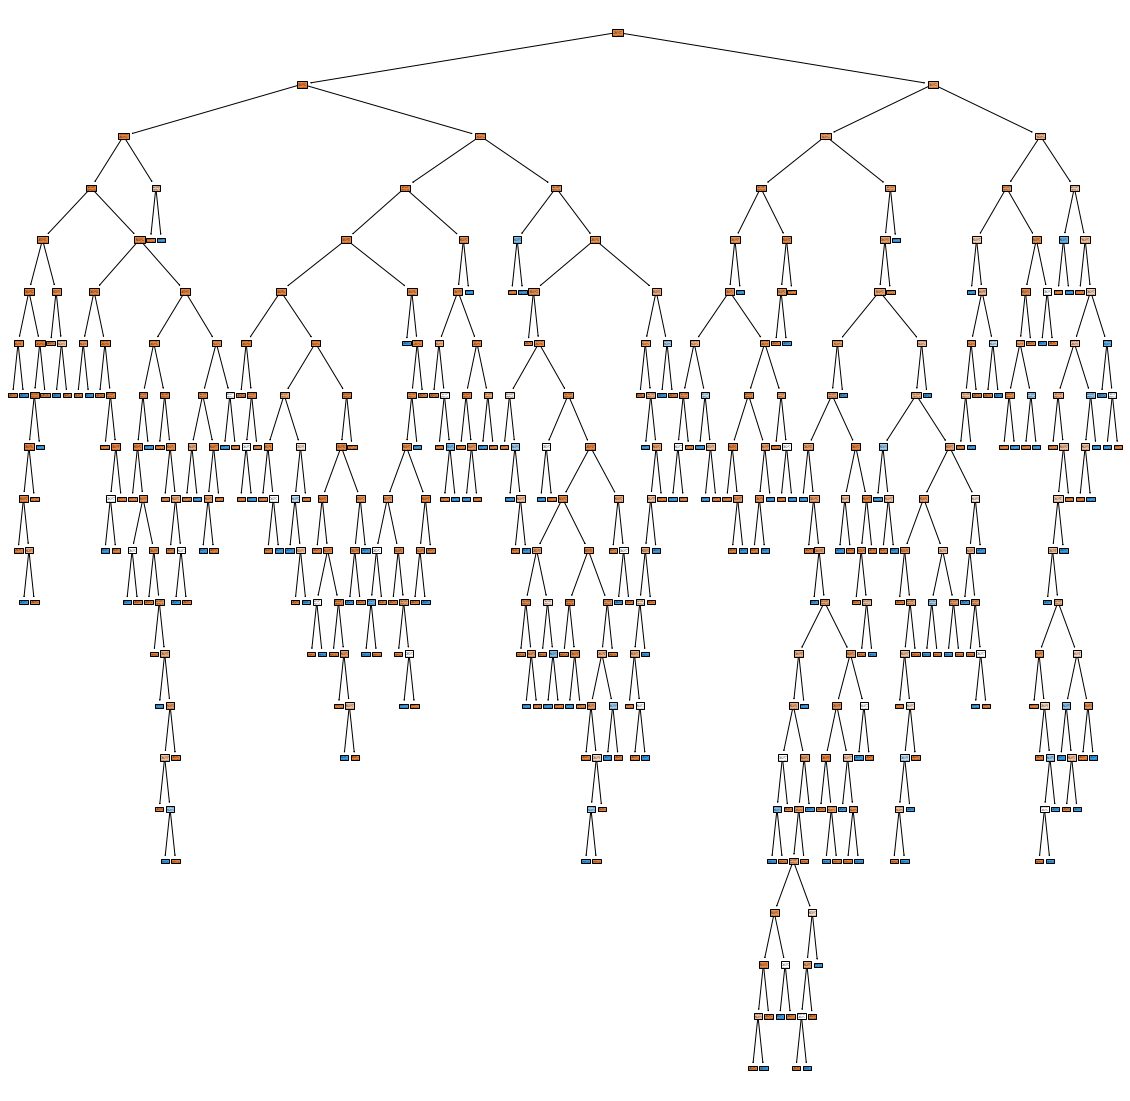

In [ ]:
# TODO: visualize the resulting tree
plt.figure(figsize=(20, 20))
plot_tree(dt_clf, filled=True)
plt.show()

As we see above, and as we saw in lecture, the default tree left unchecked can grow pretty large if there is no maximum depth set. Instead of choosing a random depth lets set one by determining the size that maximizes accuracy on the training and test set.

In [ ]:
# TODO: vary the maximum depth parameter from 1-20 and calculate the accuracy
# on the training and test set
# NOTE: it is okay to use a for loop here

max_accuracy = -1
depth = []
accuracy_train = []
accuracy_test = []

# Iterate through each depth
for max_depth in range(1, 21):
  # Train dt on training data
  dt_clf = DecisionTreeClassifier(max_depth=max_depth)
  dt_clf = dt_clf.fit(norm_train, y_train)

  # predict the test set
  pred_test = dt_clf.predict(norm_test)
  test = accuracy_score(y_test, pred_test)

  # predict the training set
  pred_train = dt_clf.predict(norm_train)
  train = accuracy_score(y_train, pred_train)

  depth.append(max_depth)
  accuracy_train.append(train)
  accuracy_test.append(test)

# create the DataFrame
df_test = pd.DataFrame({"max_depth":depth, "accuracy":accuracy_test})
df_test["type"] = "Test"
df_train = pd.DataFrame({"max_depth":depth, "accuracy":accuracy_train})
df_train["type"] = "Train"
accuracy = pd.concat([df_test, df_train])

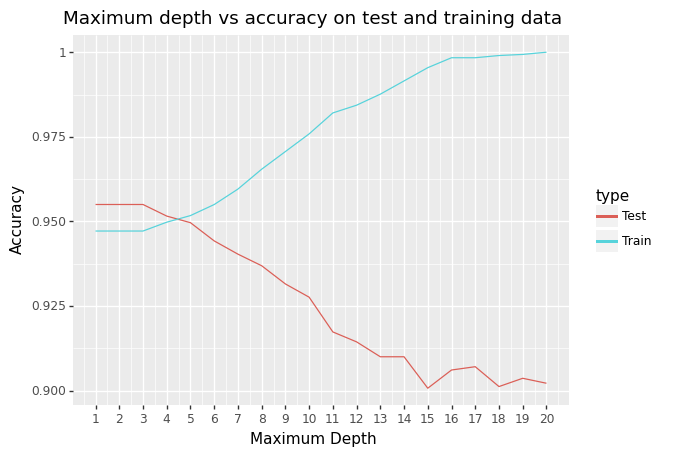

<ggplot: (8742730556733)>

In [ ]:
# TODO: make a single plot showing maximum depth vs accuracy on the test and training data

(ggplot(accuracy, aes(x='max_depth', y='accuracy', color='type'))
 + geom_line()
 + scale_x_continuous(breaks = list(range(0, 21)))
 + ggtitle('Maximum depth vs accuracy on test and training data')
 + xlab('Maximum Depth')
 + ylab('Accuracy'))

**Short Answer Question:** Which maximum depth parameter is the best choice?

`[WRITE YOUR ANSWER HERE]`

Depth 5 has the best performance because it is the depth right after where the accuracy of the test and train data sets intersect.

In [ ]:
# TODO: using the decision tree model from above with the optimal maximum depth
# determine which features are the most important. Make a dataframe of features
# and their correspondning importances to show this.

dt_clf = DecisionTreeClassifier(max_depth=5)
dt_clf = dt_clf.fit(norm_train, y_train)
pred = dt_clf.predict(norm_test)

dot_data = export_graphviz(dt_clf, feature_names=norm_train.columns.values,
                           out_file=None, filled=True, rounded=True,
                           special_characters=True)
graphviz.Source(dot_data)

pd.DataFrame({"importance_rank": [1,2,3,4,5], "feature":["age", "avg_glucose_level", "bmi", "hypertension", "heart_disease"]})

,importance_rank,feature
0,1,age
1,2,avg_glucose_level
2,3,bmi
3,4,hypertension
4,5,heart_disease


**Short Answer Question:** Looking at the features importances determined above does this match your initial expections? Why or why not?

`[WRITE YOUR ANSWER HERE]`

It does match my expectation. Age, average glucose level, bmi, hypertension, and heart disease are health conditions which has direct effect on CVA. They intuitively reflects the other less important features (e.g. smoking, marriage) which indirectly affect CVA.

### Part 2: Logistic Regression [30 points]
We achieved pretty good performance using decision trees, but lets see if we can obtain even higher accuracy by switching our ML algorithm to logistic regression. In this next section we will explore logistic regression and look deeper into the model weights to better understand which data set features are important for stroke prediction.

In [ ]:
# TODO: run logistic regression with default parameters on the unscaled,
# one-hot encoded feature set and calculate accuracy on the test set

lr_clf = LogisticRegression(penalty="none")
lr_clf = lr_clf.fit(encoded_train, y_train)
pred = lr_clf.predict(encoded_test)
accuracy_score(y_test, pred)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.9549902152641878

In [ ]:
# TODO: run logistic regression on the scaled and one-hot encoded features
# and evaluate on test set

lr_clf = LogisticRegression(penalty="none")
lr_clf = lr_clf.fit(norm_train, y_train)
pred = lr_clf.predict(norm_test)
accuracy_score(y_test, pred)

0.9549902152641878

**Short Answer Question:** Does scaling have an effect on the performance for logistic regression? Why or why not?

`[WRITE YOUR ANSWER HERE]`

No, scaling has no effect on the performance of logistic regression because scaling retains the ranking between data.

In [ ]:
# TODO: extract the feature coefficients from the above logistic regression model

lr_coefs = pd.DataFrame({'feature':norm_train.columns, 'lr_coef': lr_clf.coef_.transpose().flatten()})
lr_coefs.sort_values('lr_coef')

,feature,lr_coef
14,work_type_Self-employed,-1.541013
11,work_type_Govt_job,-1.539995
13,work_type_Private,-1.164455
5,hypertension_0,-0.925072
7,heart_disease_0,-0.902080
16,residence_type_Rural,-0.854567
9,ever_married_No,-0.831626
4,sex_Male,-0.826055
3,sex_Female,-0.742335
10,ever_married_Yes,-0.736764


**Short Answer Question:** Based on the above weights are the following features associated with an increased or a decreased chance of a CVA: living in an urban area, being married, bmi?

`[WRITE YOUR ANSWER HERE]`

urban area: negative coefficient, so it is associated with a decreased chance of a CVA

being married: negative coefficient, so it is associated with a decreased chance of CVA

bmi: positive coefficient, so it is associated with an increased chance of CVA

We were able to extract a nice set of feature weights above - let's see what effects different solvers and regularization schemes have on the feature weights.

In [ ]:
# TODO: run logistic regression with the liblinear solver with L1, L2,
# and lbfgs with no regularization, extracting the coefficients each time for
# comparison
# NOTE: it is okay to use for loops here; in fact, you are encouraged to do so
# versus repeating the same code multiple times
penalties = ['l1', 'l2', 'lbfgs']
dfs = []
for penalty in penalties:
  lr_clf = LogisticRegression()
  if penalty != 'lbfgs':
    lr_clf = LogisticRegression(penalty=penalty, solver='liblinear')
  lr_clf = lr_clf.fit(encoded_train, y_train)
  pred = lr_clf.predict(encoded_test)
  lr_coefs = pd.DataFrame({'feature':encoded_train.columns, 'lr_coef' + "_" + penalty: lr_clf.coef_.transpose().flatten()})
  dfs.append(lr_coefs)

merged = pd.merge(dfs[0], dfs[1], on=['feature'], how='inner')
merged = pd.merge(merged, dfs[2], on=['feature'], how='inner')
merged

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


,feature,lr_coef_l1,lr_coef_l2,lr_coef_lbfgs
0,sex_Female,0.000000,-0.736940,-0.774659
1,sex_Male,-0.056503,-0.813527,-0.813018
2,hypertension_0,-0.313270,-0.945494,-0.985421
3,hypertension_1,0.000000,-0.604972,-0.602256
4,heart_disease_0,-0.265477,-0.925586,-0.926280
5,heart_disease_1,0.000000,-0.624881,-0.661397
6,ever_married_No,0.000000,-0.784373,-0.775734
7,ever_married_Yes,0.000000,-0.766094,-0.811944
8,work_type_Govt_job,-0.319538,-0.913861,-0.576461
9,work_type_Never_worked,0.000000,0.808517,0.171051


**Short Answer Question:** Do the different regularization methods change the feature weights? If so, which features are affected?

`[WRITE YOUR ANSWER HERE]`

Yes, different regularization methods change the feature weights.

All features are affected. However, compared to all other features, age is minimally affected.

**Short Answer Question:** Furthermore, based on the feature weights across the different regularization schemes above would you say that regularization helps prevent overfitting in this case? Explain.

`[WRITE YOUR ANSWER HERE]`

l1 because it changes many features to have 0 regularization meaning that it will less affect the prediction.

### Part 3: Linear Discriminant Analysis and Final Performance Evaluation [12 points]
In this section we will quickly apply one more ML algorithm, LDA, and then make some final observations across all three different classification models.

In [ ]:
# TODO: run LDA with default settings on the features (with numeric scaled, one-hot encoded categorical)
# and calculate accuracy on the test set

lda = LinearDiscriminantAnalysis()
lda = lda.fit(norm_train, y_train)
pred = lda.predict(norm_test)
accuracy_score(y_test, pred)

0.9500978473581213

In [ ]:
# TODO: extract coefficients from LDA

lda_coefs = pd.DataFrame({'feature':norm_train.columns, 'lda_coef': lda.coef_.transpose().flatten()})
lda_coefs.sort_values('lda_coef')

,feature,lda_coef
2,bmi,-1.163749
11,work_type_Govt_job,-0.606379
7,heart_disease_0,-0.524481
14,work_type_Self-employed,-0.488158
5,hypertension_0,-0.364904
10,ever_married_Yes,-0.292638
20,smoking_status_never smoked,-0.124013
16,residence_type_Rural,-0.097146
4,sex_Male,-0.062725
13,work_type_Private,-0.036988


**Short Answer Question:** Can the coefficients that are extracted from LDA be interpreted as feature importances? Why or why not?

`[WRITE YOUR ANSWER HERE]`

No. Eventhough, age has a high co-efficient (high importance) which aligns with the other classifier models, the other features are not aligned (e.g.work_type is the second important and bmi is the least important which does not align with the second). LDA simply identify feature which separates the data well which does not mean that they are good predictors for CVA.

**Short Answer Question:** Now that you have run three different classsification methods (decision trees, logistic regression, LDA) with various parameters which method do you think is best suited for the CVA prediction problem? Explain.

`[WRITE YOUR ANSWER HERE]`

I think that logistic regression is best suited for CVA prediction because it has the highest acuracy out of all the methods.

**Short Answer Question:** Which method would you use for identifying risk factors for CVAs? Explain.

`[WRITE YOUR ANSWER HERE]`

I would use logistic regression with L1 regularization to identifying risk factors because logistic regression coefficients are intuitive, making it easy to understand which feature causes CVA and which feature don't. The magnitude of the coefficients also suggests feature importance.

Moreover, L1 regularization also reduces overfitting, making the model more generalizable.

### Bonus: Plotting Functions [Extra Credit: up to 10 points]

Using plotnine (matplotlib or seaborn solutions are not eligible for extra credit points in this assignment), write a function to visualize an underlying model given the fitted model object from scikit-learn (aka the output when calling the fit function).

You can choose to write a function to display a sigmoid curve for each feature (with training observations as points) for logistic regression or a plot showing the classification line and corresponding training points for LDA.

Each function will be worth up to 5 points, with full points given for solutions that are efficient and informative. Demonstrate that your function(s) work by plotting one of the above logistic regression or LDA models.

In [ ]:
# EXTRA CREDIT: TODO: Write a function to visualize a logistic regression model + demonstrate it works

In [ ]:
# EXTRA CREDIT: TODO: Write a function to visualize an LDA model + demonstrate it works

## To Submit
Download the notebook from Colab as a `.ipynb` notebook (`File > Download > Download .ipynb`) and upload it to the corresponding Gradescope assignment. Your assignment should be named `comp341-hw3.ipynb`.